#2η ομαδική άσκηση στη Τεχνολογία και Ανάλυση Εικόνων και Βίντεο

## Εισαγωγή και επισκόπηση του συνόλου δεδομένων

In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals # legacy compatibility

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
# helper functions

# select from from_list elements with index in index_list
def select_from_list(from_list, index_list):
  filtered_list= [from_list[i] for i in index_list]
  return(filtered_list)

# append in filtered_list the index of each element of unfilterd_list if it exists in in target_list
def get_ds_index(unfiliterd_list, target_list):
  index = 0
  filtered_list=[]
  for i_ in unfiliterd_list:
    if i_[0] in target_list:
      filtered_list.append(index)
    index += 1
  return(filtered_list)

# select a url for a unique subset of CIFAR-100 with 20, 40, 60, or 80 classes
def select_classes_number(classes_number = 20):
  cifar100_20_classes_url = "https://pastebin.com/raw/nzE1n98V"
  cifar100_40_classes_url = "https://pastebin.com/raw/zGX4mCNP"
  cifar100_60_classes_url = "https://pastebin.com/raw/nsDTd3Qn"
  cifar100_80_classes_url = "https://pastebin.com/raw/SNbXz700"
  if classes_number == 20:
    return cifar100_20_classes_url
  elif classes_number == 40:
    return cifar100_40_classes_url
  elif classes_number == 60:
    return cifar100_60_classes_url
  elif classes_number == 80:
    return cifar100_80_classes_url
  else:
    return -1

In [ ]:
# load the entire dataset
import tensorflow as tf
from tensorflow.keras import datasets, layers, models

(x_train_all, y_train_all), (x_test_all, y_test_all) = tf.keras.datasets.cifar100.load_data(label_mode='fine')

169009152/169001437 [==============================] - 2s 0us/step


In [ ]:
print(x_train_all.shape)

(50000, 32, 32, 3)


Η κάθε ομάδα θα δουλέψει με διαφορετικό υποσύνολο του dataset.
Στο επόμενο κελί, αντικαταστήστε την τιμή της μεταβλητής `team_seed` με τον αριθμό που αντιστοιχεί στην ομάδας σας. 

In [ ]:
# REPLACE WITH YOUR TEAM NUMBER
team_seed = 13

Στο επόμενο κελί μπορείτε να διαλέξετε το πλήθος των κατηγορίων σας: 20 (default), 40, 60 ή 80.

In [ ]:
# select the number of classes
cifar100_classes_url = select_classes_number()

Δημιουργούμε το μοναδικό dataset της ομάδας μας:

In [ ]:
team_classes = pd.read_csv(cifar100_classes_url, sep=',', header=None)
CIFAR100_LABELS_LIST = pd.read_csv('https://pastebin.com/raw/qgDaNggt', sep=',', header=None).astype(str).values.tolist()[0]

our_index = team_classes.iloc[team_seed,:].values.tolist()
our_classes = select_from_list(CIFAR100_LABELS_LIST, our_index)
train_index = get_ds_index(y_train_all, our_index)
test_index = get_ds_index(y_test_all, our_index)

x_train_ds = np.asarray(select_from_list(x_train_all, train_index))
y_train_ds = np.asarray(select_from_list(y_train_all, train_index))
x_test_ds = np.asarray(select_from_list(x_test_all, test_index))
y_test_ds = np.asarray(select_from_list(y_test_all, test_index))

In [ ]:
# print our classes
print(our_classes)

[' beaver', ' castle', ' caterpillar', ' chair', ' cup', ' dolphin', ' hamster', ' keyboard', ' lobster', ' oak_tree', ' otter', ' pear', ' snake', ' sweet_pepper', ' tank', ' telephone', ' television', ' tiger', ' whale', ' wolf']


In [ ]:
print(x_train_ds[1].shape)

(32, 32, 3)


Train: X=(8500, 32, 32, 3), y=(8500, 1)
Validation: X=(1500, 32, 32, 3), y=(1500, 1)
Test: X=(2000, 32, 32, 3), y=(2000, 1)


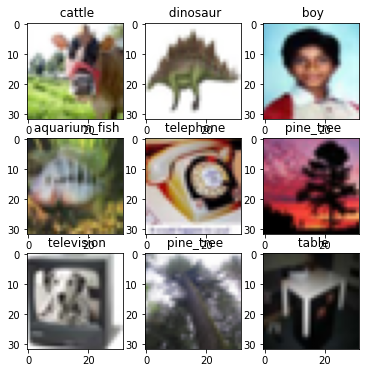

In [ ]:
# get (train) dataset dimensions
data_size, img_rows, img_cols, img_channels = x_train_ds.shape

# set validation set percentage (wrt the training set size)
validation_percentage = 0.15
val_size = round(validation_percentage * data_size)

# Reserve val_size samples for validation and normalize all values
x_val = x_train_ds[-val_size:]/255
y_val = y_train_ds[-val_size:]
x_train = x_train_ds[:-val_size]/255
y_train = y_train_ds[:-val_size]
x_test = x_test_ds/255
y_test = y_test_ds

# summarize loaded dataset
print('Train: X=%s, y=%s' % (x_train.shape, y_train.shape))
print('Validation: X=%s, y=%s' % (x_val.shape, y_val.shape))
print('Test: X=%s, y=%s' % (x_test.shape, y_test.shape))

# get class label from class index
def class_label_from_index(fine_category):
  return(CIFAR100_LABELS_LIST[fine_category.item(0)])

# plot first few images
plt.figure(figsize=(6, 6))
for i in range(9):
	# define subplot
  plt.subplot(330 + 1 + i).set_title(class_label_from_index(y_train[i]))
	# plot raw pixel data
  plt.imshow(x_train[i], cmap=plt.get_cmap('gray'))
  #show the figure
plt.show()

## Διαχείριση μνήμης (TFRecord)
Η φόρτωση δεδομένων με τον τρόπο που το κάναμε παραπάνω στο απλό παράδειγμα υλοποίησης είναι πολύ βολική αλλά δεν είναι καθόλου αποτελεσματική ως προς τη διαχείριση της μνήμης. Συγκεκριμένα, με τον τρόπο αυτό, τα δεδομένα αποθηκεύονται απευθείας σε μεταβλητές, οι οποίες όλες μαζί καταλαμβάνουν τη RAM της CPU ή της GPU, κάτι που κάνει αδύνατη τη διαχείριση μεγάλων datasets ή τον μεταχηματισμό των δεδομένων όπως όταν κάνουμε αύξηση δεδομένων (data augmentation).

Για να παρακαμφθεί αυτό το πρόβλημα, υπάρχει η δυνατότητα της σειριοποίησης των δεδομένων (serialization) και της αποθήκευσής τους σε αρχεία μεσαίου μεγέθους (κάποιων MB) τα οποία μπορούν να αναγνωστούν γραμμικά. Το φορμάτ TFRecord είναι ένα φορμάτ που επιτρέπει την αποθήκευση σειράς δυαδικών εγγραφών. Διαβάστε τα σχετικά λήμματα [TFRecord and tf.Example](https://www.tensorflow.org/tutorials/load_data/tfrecord) και [tf.data: Build TensorFlow input pipelines](https://www.tensorflow.org/guide/data). 

Σημειώστε ότι με τη μέθοδο αυτή θα πρέπει να γίνει import η `tensorflow_datasets` και να χρησιμοποιήσουμε την `tfds.load` ώστε να αποθηκευθεί το σύνολο δεδομένων σε αρχεία tfrecord στο δίσκο (δείτε [εδώ](https://colab.research.google.com/github/tensorflow/datasets/blob/master/docs/overview.ipynb) ένα παράδειγμα). Φυσικά μπορούμε να μετατρέψουμε και τα πρωτογενή δεδομένα (raw data) του dataset όπως αρχεία jpg σε φορματ tfrecord όπως [εδώ](https://towardsdatascience.com/working-with-tfrecords-and-tf-train-example-36d111b3ff4d).


## Ερώτημα 1

#### Βήμα 1: Σχεδίαση, μεταγλώττιση και εκπαίδευση των μοντέλων



1.1.  Σχεδίασετε αρχικά τα ακόλουθα μοντέλα:

  1.   **Softmax (baseline)**: FC(200), SOFTMAX

  2.   **MLP**: FC(512), RELU, FC(200), SOFTMAX

  3.   **LeNet**: CONV(32, 3), RELU, POOL(2), CONV(32,3), RELU, POOL(2), FC(512, RELU, FC(200),SOFTMAX

  4. **CNN1**: CONV(16, 5), RELU, POOL(2), CONV(16,3), RELU, POOL(2), CONV(32, 3), RELU, FC(200), SOFTMAX

  5. **CNN2**: σχεδίαστε την αρχιτεκτονική του και δικού σας μοντέλου 

1.2.  Μεταγλωτίστε και εκπαιδεύστε, έπειτα,  όλα τα μοντέλα σας, χρησιμοποιώντας 2 διαφορετικούς (καλύτερους) συνδυασμούς optimizer, loss, metrics και epoch (θα προκύψουν 10 διαφορετικά εκπαιδευμένα μοντέλα, 2 ανά αρχιτεκτονική). 

---

#### Βήμα 2: Αξιολόγηση των μοντέλων

2.1. Για κάθε ένα από τα μοντέλα που εκπαιδεύσατε, απεικονίστε σε κοινό διάγραμμα την ακρίβεια εκπαίδευσης και την ακρίβεια επικύρωσης στο σύνολο των εποχών, για κάθε διαφορετικό συνδυασμό του βήματος 1.2 (10 διαγράμματα) και επιλέξτε αυτό με την καλύτερη ακρίβεια από κάθε μοντέλο (ένα από κάθε αρχιτεκτονική, συνολικά 5).


2.2. Για κάθε ένα από τα μοντέλα με την καλύτερη ακρίβεια(συνολικά 5), απεικονίστε σε κοινό διάγραμμα την ακρίβεια εκπαίδευσης και την ακρίβεια επικύρωσης στο σύνολο των εποχών.


2.3. Αξιολογήστε, αναλυτικά, τα αποτελέσματά σας ως προς τα εξής:

 - Επίδραση του πλήθους των δεδομένων/κλάσεων στην απόδοση του μοντέλου
 - Επίδραση του αλγόριθμου βελτιστοποίησης (optimizer)
 - Επίδραση του μεγέθους δέσμης (batch size)
 
---

#### Βήμα 3

Αξιολογήστε την ακρίβεια για το test set σας.


**Προσοχή** 

Για τα επόμενα ερωτήματα θα κρατήσετε το μοντέλο που αντιστοιχεί στον καλύτερο συνδυασμό ( optimizer, loss, metrics και epoch) από τα μοντέλα που εκπαιδεύσατε (και για τα 5 μοντέλα - όπως στο Ερώτημα 1, βήμα 2.2).

## Ερώτημα 2

### Βήμα 1: Έλεγχος υπερεκπαίδευσης

  1.1. Προτείνετε τεχνικές που θα χρησιμοποιήσετε για να αντιμετωπίσετε το πρόβλημα της υπερεκπαίδεσης και υλοποιήστε τις τεχνικές που προτείνετε για την εκπαίδευση του μοντέλου ώστε αυτό να γενικεύει καλύτερα.

Δοκιμάστε διάφορους τρόπους για τον έλεγχο της υπερεκπαίδευσης (overfitting), όπως:

- Πρόωρος τερματισμός (early stopping). Μια μέθοδος που τερματίζει την εκπαίδευση αν δεν υπάρχει βελτίωση ως προς τη μετρική απόδοσης που παρακολουθούμε. [tf.keras.callbacks.EarlyStopping](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStoppinghttps://)

- Dropout. Μια άλλη τεχνική για τη μείωση της υπερεκπαίδευσης είναι το Dropout. Είναι ένα είδος ομαλοποίησης (regularization) που επιβάλλει στα βάρη του δικτύου να παίρνουν μόνο μικρές τιμές. Εάν εφαρμόσουε dropout σε ένα επίπεδο του δικτύου, τότε ένα ποσοστό των βαρών του γίνεται τυχαία μηδενικό κατά την εκπαίδευση. [Dropout](https://www.tensorflow.org/tutorials/images/classification#dropout)

- Επαύξηση δεδομένων. Η υπερεκπαίδευση συνήθως συμβαίνει όταν έχουμε λίγα ή/και πολύ όμοια δεδομένα εκπαίδευσης. Ένας τρόπος να διορθωθεί αυτό το πρόβλημα είναι να αυξήσουμε τα δεδομένα (data augmentation). Το data augmentation δημιουργεί νέα δεδομένα εκπαίδευσης με βάση τα υπάρχοντα εφαρμόζοντας τυχαίους μετασχηματισμούς ώστε να προκύπτουν αληθοφανείς εικόνες. [Data augmentation](https://www.tensorflow.org/tutorials/images/classification#data_augmentation), [ImageDataGenerator](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator#class_imagedatagenerator)

### Βήμα 2
Αξιολογήστε την ακρίβεια για το validation και το test set σας.

## Ερώτημα 3

Εφαρμόστε transfer learning, **χρησιμοποιώντας κατάλληλα επίπεδα, όπως την κεφαλή ταξινόμησης**,  από το δικό σας μοντέλο (CNN2), που αξιολογήσατε ως καλύτερο προς την ακρίβειά, στην αντιμετώπιση της υπερεκπαίδεσης. (Το καλύτερο μοντέλο που προέκυψε από το βήμα 2 του ερωτήματος 2). 

Για το transfer learning επιλέξτε, ένα από τα διαθέσιμα μοντέλα για μεταφορά μάθησης.

**Διευκρίνιση**
*Ταυτόχρονα με την αρχιτεκτονική, στη μεταφορά μάθησης εισάγουμε και τη γνώση που έχει αποκτήσει το μοντέλο, δηλαδή τις τιμές των βαρών του όπως έχουν προκύψει μετά από εκπαίδευση συνήθως στο (τεράστιο) ImageNet.*


### Βήμα 1
"Παγώστε" τη συνελικτική βάση και εκπαιδεύστε την κεφαλή ταξινόμησης (classification head - σημαία trainable = False).  


### Βήμα 2
  Εκπαιδέστε μόνο ένα ποσοστό των επιπέδων, το οποίο βρίσκεται προς την έξοδο του δικτύου. Οι σημαίες trainable εδώ θα πρέπει να οριστούν ανά επίπεδο.

### Βήμα 3 
Αξιολογήστε τα αποτελέσματά σας, βάσει της ακρίβειας του validation set και του test set σας, για τα προηγούμενα βήματα του Ερωτήματος 3 


#### Διαθέσιμα μοντέλα για μεταφορά μάθησης στο tf2 για να χρησιμοποιηθούν στην άσκηση

1. tf.keras.applications. Ο πιο απλός τρόπος για να κάνουμε μεταφορά μάθησης στο tf2 είναι μέσω του [tf.keras.applications](https://www.tensorflow.org/api_docs/python/tf/keras/applications) που παρέχει προεκπαιδευμένα μοντέλα από το Keras και συγκεκριμένα τα δίκτυα: DenseNet, Inception-ResNet V2, Inception V3, MobileNet v1, MobileNet v2, NASNet-A, ResNet, ResNet v2, VGG16, VGG19 και Xception V1. Η εισαγωγή των μοντέλων γίνεται παρόμοια με αυτή που δείξαμε παραπάνω για το VGG16.

2. TensorFlow Hub. Μπορείτε επίσης να χρησιμοποιήσετε μοντέλα τα οποία είναι διαθέσιμα στο αποθετήριο [TensoFlow Hub](https://tfhub.dev/s?fine-tunable=yes&module-type=image-augmentation,image-classification,image-feature-vector,image-generator,image-object-detection,image-others,image-style-transfer,image-rnn-agent&tf-version=tf2) το οποίο περιλαμβάνει πάνω από 100 προεκπαιδευμένα μοντέλα.


Σημειώστε ότι πολλά μοντέλα απαιτούν μεγαλύτερες διαστάσεις στην είσοδο από 
αυτές του CIFAR-100 και κατά συνέπεια τα δεδομένα πρέπει να [μετασχηματιστούν](https://www.tensorflow.org/api_docs/python/tf/image/resize). Προσέξτε ωστόσο τις απαιτήσεις σε μνήμη όταν αυτοί οι μετασχηματισμοί γίνονται απευθείας σε μεταβλητές (δες "Διαχείριση μνήμης"). 


### Εργαλεία υψηλού επιπέδου

Δεν είναι υποχρεωτικό στο πλαίσιο της άσκησης, αλλά αν  κάποιος επιθυμεί μπορεί να ασχοληθεί περαιτέρω με εργαλεία βελτιστοποίησης υψηλού επιπέδου (high-level). 


Για το TensorFlow μπορούμε να αναφέρουμε τα ακόλουθα:

- [TensorBoard](https://www.tensorflow.org/tensorboard/get_started) και [What-If Tool](https://www.tensorflow.org/tensorboard/what_if_tool) Επικουρικό εργαλείο οπτικοποίησης για τον πειραματισμό στη Μηχανική Μάθηση
- [tf-explain](https://tf-explain.readthedocs.io/en/latest/) Προσφέρει μεθόδους επεξηγισιμότητας για το tf2
- [Keras Tuner](https://github.com/keras-team/keras-tuner) Βελτιστοποίηση υπερπαραμέτρων του Keras στο TensorFlow 2.0
- [AutoAugment](https://github.com/tensorflow/models/tree/master/research/autoaugment) Εκμάθηση της πολιτικης επαύξησης από τα δεδομένα